# Data Analysis on Directors, Producers, Actors, Actresses, Writers

## The goal of this data analysis is to suggest people to staff for the movie in regards their success. Success is measured using ROI. We reviewed directors, actors, actresses, producers, and writers. This dataset is from 2010-2020. 

First we locate the dataframe we want to reference separating them by role. This notebook is broken down by each role, using the same code in each to find suitable candidates to suggest.

In [2]:
## Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import sqlite3

#This is to query the data set below. This is not necesary with learn-env, but is with ipykernel
#! pip install -U pandasql

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [3]:
# References the master dataset in the notebook. Drops the records where gross=0, since this is likely an error in the data.

master_df = pd.read_pickle('movie_master_dataset_with_inflation.pkl')
master_df = master_df[master_df['worldwide_gross'] != 0]

In [4]:
##data is from 2010-2020
master_df['release_date'].dt.year.value_counts() 

2011    1729
2014    1648
2010    1645
2015    1605
2013    1585
2016    1532
2012    1476
2017    1181
2018    1179
2019     330
Name: release_date, dtype: int64

In [5]:
master_df.head()

,release_date,movie,production_budget,inf_adj_production_budget,domestic_gross,worldwide_gross,worldwide_profit,ROI,person_name,movie_role,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,539310899,241063875,1045663875,635063875,1.546673,Johnny Depp,actor,...,False,False,False,False,False,False,False,False,False,False
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,539310899,241063875,1045663875,635063875,1.546673,Geoffrey Rush,actor,...,False,False,False,False,False,False,False,False,False,False
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,539310899,241063875,1045663875,635063875,1.546673,Penélope Cruz,actress,...,False,False,False,False,False,False,False,False,False,False
3,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,539310899,241063875,1045663875,635063875,1.546673,Stuart Beattie,writer,...,False,False,False,False,False,False,False,False,False,False
4,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,539310899,241063875,1045663875,635063875,1.546673,Ted Elliott,writer,...,False,False,False,False,False,False,False,False,False,False


In [6]:
master_df['movie_role'].value_counts().head() ##types of roles. There are almost twice as many actors as actresses

actor       3486
producer    2747
writer      2663
actress     2028
director    1502
Name: movie_role, dtype: int64

<b>The cell below gets the stats for movies with a budget over 10 million - to rule out independent and smaller films. 
We will reference the median, as it is robust to outliers.</b>

In [7]:
master_df[master_df['inf_adj_production_budget'] > 1e7]['inf_adj_production_budget'].describe()

count    1.112700e+04
mean     7.473626e+07
std      7.376893e+07
min      1.003858e+07
25%      2.458659e+07
50%      4.510984e+07
75%      9.983165e+07
max      5.393109e+08
Name: inf_adj_production_budget, dtype: float64

<b>Takeaway: 
   The budget 25% percentile is 2.4 million
   The median is 4.5 million
   The 75% is 9.9 million
    

<b>Establish new dateframes that orangize by role. Directors, Actors, Actresses, Producers, Writers.</b>

In [8]:
directors = master_df[master_df['movie_role'] == "director"] ##dataframe of directors only

In [9]:
actors = master_df.loc[master_df['movie_role'] == "actor"] ##dataframe of actors only

In [10]:
actresses = master_df.loc[master_df['movie_role'] == "actress"] ##dataframe of actresses only

In [11]:
producers = master_df[master_df['movie_role'] == "producer"]##dataframe of producers only

In [12]:
writers = master_df[master_df['movie_role'] == "writer"] ##dataframe of writers only

## DIRECTORS

### This section outlines director recommendations. We use a sequence of queries, and loops to narrow the directors that were a part of movies using a 24mil+ budget, and directed at least 3 movies since 2010. 


In [13]:
## The following cell queries the directors dataframe with a $30Mill+ budget.

dq1 = ("""
SELECT person_name, movie, inf_adj_production_budget, ROI, Comedy, Adventure, Action
FROM directors
WHERE inf_adj_production_budget >= 2.4e7
ORDER BY ROI
""")

directors_q1 = pysqldf(dq1) 
directors_q1

,person_name,movie,inf_adj_production_budget,ROI,Comedy,Adventure,Action
0,Lawrence Kasanoff,Foodfight!,58169890,-0.998362,1,0,1
1,Robbie Pickering,Freaks of Nature,41180555,-0.997850,1,0,0
2,David O. Russell,Accidental Love,32681495,-0.994791,1,0,0
3,Taylor Hackford,Love Ranch,34041818,-0.994154,1,0,0
4,Xiao Feng,Air Strike,76286869,-0.992057,0,1,1
...,...,...,...,...,...,...,...
906,Kyle Balda,Minions,92028535,14.680219,1,1,0
907,James Wan,The Conjuring,25411137,14.900007,0,0,0
908,Bryan Singer,Bohemian Rhapsody,64767356,15.272461,0,0,0
909,Andy Muschietti,It,42087096,18.927371,0,0,0


In [14]:
#This loop sorts by number of movies, and selects the ones that have made 3 or more

three_movies_dq1 = []
for x, y in zip(directors_q1['person_name'].value_counts(), directors_q1['person_name'].value_counts().index.tolist()):
    if x >= 3:
        three_movies_dq1.append(y)
    
three_movies_dq1

['Steven Spielberg',
 'Clint Eastwood',
 'Ridley Scott',
 'Zack Snyder',
 'Peter Berg',
 'Ron Howard',
 'Francis Lawrence',
 'Antoine Fuqua',
 'Baltasar Kormákur',
 'Paul W.S. Anderson',
 'Jaume Collet-Serra',
 'Brad Peyton',
 'Peter Farrelly',
 'Lasse Hallström',
 'Adam McKay',
 'Martin Scorsese',
 'Joe Wright',
 'Mike Mitchell',
 'Robert Zemeckis',
 'Michael Bay',
 'Jonathan Levine',
 'Bryan Singer',
 'Christopher Nolan',
 'Simon West',
 'Tim Burton',
 'Denis Villeneuve',
 'Chris Renaud',
 'David O. Russell',
 'Nicholas Stoller',
 'Shawn Levy',
 'Tim Story',
 'Jon M. Chu',
 'David Yates',
 'Joe Johnston',
 'Phil Lord',
 'David Ayer',
 'Joe Russo',
 'Roland Emmerich',
 'Guy Ritchie',
 'Robert Rodriguez',
 'Dennis Dugan',
 'Craig Gillespie',
 'Louis Leterrier',
 'Genndy Tartakovsky',
 'Malcolm D. Lee',
 'Paul Greengrass',
 'Seth Gordon',
 'Sean Anders',
 'Peter Jackson',
 'Don Hall',
 'Andy Fickman',
 'Dean DeBlois',
 'Paul Feig',
 'Jake Kasdan',
 'Steven Soderbergh',
 'George Tillman 

<b>Get the ROI of all the directors and get the mean of those ROIs for each individual. Then they must be involved in Action, Adventure, and Comedy.</b>

In [16]:
# This gets two lists, one is the names of directors, the other is the respective ROIs. 
# This loop also sorts by genres Action, Adventure, Comedy.

names_df1 = []
ROI_df1 = []
for x in three_movies_dq1:
    ROI_df1_mean = directors_q1[directors_q1['person_name'] == x]['ROI'].mean()
    this_actor = directors_q1[directors_q1['person_name'] == x]
    if this_actor['Action'].sum() + this_actor['Adventure'].sum() + this_actor['Comedy'].sum() > 0:
        names_df1.append(x)
        ROI_df1.append(ROI_df1_mean)

#This zips the above loops and puts them into a dataframe. The dataframe will be used for visualization.
    
zipped_name_ROI_df1 = sorted(zip(names_df1, ROI_df1), reverse=True)
df1 = pd.DataFrame(zipped_name_ROI_df1, columns=['Director Names', 'Average ROI'])
df1.sort_values(by='Average ROI', ascending=False, inplace=True)
df1

,Director Names,Average ROI
22,Pierre Coffin,10.501490
50,James Wan,9.353792
75,Chris Renaud,7.487083
53,Jake Kasdan,7.402594
23,Phil Lord,5.361456
...,...,...
16,Roland Emmerich,0.424337
8,Simon West,0.393356
18,Robert Rodriguez,0.303165
71,Craig Gillespie,0.207672


<b>Plot the figures to show directors and their respective avergage ROI.</b>

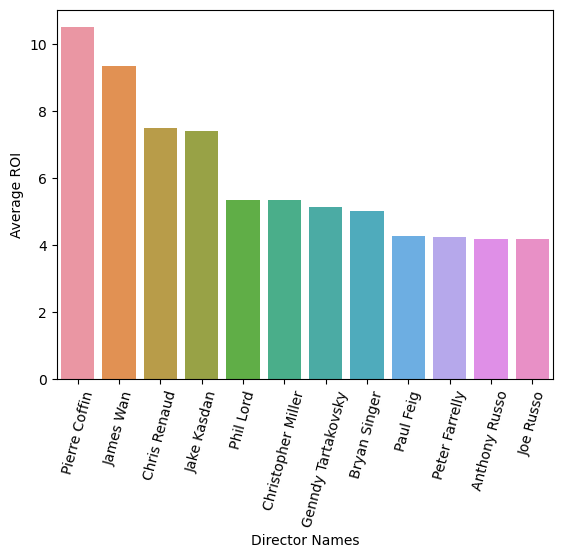

In [17]:

sns.barplot(data=df1.head(12), x='Director Names', y="Average ROI")
 
# Rotate x-labels
plt.xticks(rotation=75)
plt.show()

# ACTORS

### This section outlines actor recommendations. We use a sequence of queries, and loops to narrow the actors that were a part of movies using a 24mil+ budget, and were casted in at least 3 movies since 2010.¶

In [18]:
## This cell queries the actors dataframe with a $24Mill+ budget.

aq1 = ("""
SELECT person_name, movie, inf_adj_production_budget, ROI, Comedy, Adventure, Action
FROM actors
WHERE inf_adj_production_budget >= 2.4e7
ORDER BY ROI
""")

actors_q1 = pysqldf(aq1)

In [19]:
actors_q1

,person_name,movie,inf_adj_production_budget,ROI,Comedy,Adventure,Action
0,Charlie Sheen,Foodfight!,58169890,-0.998362,1,0,1
1,Denis Leary,Freaks of Nature,41180555,-0.997850,1,0,0
2,Nicholas Braun,Freaks of Nature,41180555,-0.997850,1,0,0
3,Josh Fadem,Freaks of Nature,41180555,-0.997850,1,0,0
4,Raymond L. Brown Jr.,Accidental Love,32681495,-0.994791,1,0,0
...,...,...,...,...,...,...,...
2243,Bill Skarsgård,It,42087096,18.927371,0,0,0
2244,Jaeden Martell,It,42087096,18.927371,0,0,0
2245,Finn Wolfhard,It,42087096,18.927371,0,0,0
2246,Ryan Gosling,La La Land,24586384,20.317558,1,0,0


In [20]:
#This loop sorts by number of movies, and selects the actors that have been casted 3 or more

three_movies_aq1 = []
for x, y in zip(actors_q1['person_name'].value_counts(), actors_q1['person_name'].value_counts().index.tolist()):
    if x >= 3:
        three_movies_aq1.append(y)
    
three_movies_aq1

['Mark Wahlberg',
 'Dwayne Johnson',
 'Liam Neeson',
 'Owen Wilson',
 'Steve Carell',
 'Johnny Depp',
 'Jason Statham',
 'Channing Tatum',
 'Chris Hemsworth',
 'Michael Fassbender',
 'Robert De Niro',
 'Tom Hardy',
 'Gary Oldman',
 'Kevin Hart',
 'Matt Damon',
 'Kevin James',
 'Morgan Freeman',
 'Tom Hanks',
 'Josh Brolin',
 'Robert Downey Jr.',
 'Denzel Washington',
 'Ryan Reynolds',
 'Bradley Cooper',
 'Gerard Butler',
 'Brad Pitt',
 'Jonah Hill',
 'Chris Pratt',
 'Will Ferrell',
 'Matthew McConaughey',
 'Jesse Eisenberg',
 'Chris Pine',
 'Adam Sandler',
 'Hugh Jackman',
 'Nicolas Cage',
 'Chris Evans',
 'James McAvoy',
 'Seth Rogen',
 'Ben Affleck',
 'Christoph Waltz',
 'Justin Timberlake',
 'John Goodman',
 'George Clooney',
 'Harrison Ford',
 'Liam Hemsworth',
 'Tom Cruise',
 'Ralph Fiennes',
 'Joel Edgerton',
 'Woody Harrelson',
 'Ryan Gosling',
 'Joseph Gordon-Levitt',
 'Jason Bateman',
 'Mark Strong',
 'Ben Stiller',
 'Mark Ruffalo',
 'Jamie Foxx',
 'James Franco',
 'Colin Farr

<b>Get the ROI of all the actors and get the mean of those ROIs for each individual. Then they must be involved in Action, Adventure, and Comedy.</b>

In [21]:
# This gets two lists, one is the names of actors, the other is the respective ROIs. 
# This loop also sorts by genres Action, Adventure, Comedy.


names_aq1 = []
ROI_aq1 = []
for x in three_movies_aq1:
    ROI_aq1_mean = actors_q1[actors_q1['person_name'] == x]['ROI'].mean()
    this_actor = actors_q1[actors_q1['person_name'] == x]
    if this_actor['Action'].sum() + this_actor['Adventure'].sum() + this_actor['Comedy'].sum() > 0:
        names_aq1.append(x)
        ROI_aq1.append(ROI_aq1_mean)

#This zips the above loops and puts them into a dataframe. The dataframe will be used for visualization.
    
zipped_name_ROI_2_aq1 = sorted(zip(names_aq1, ROI_aq1), reverse=True)
df1_aq1 = pd.DataFrame(zipped_name_ROI_2_aq1, columns=['Actor Names', 'Average ROI'])
df1_aq1.sort_values(by='Average ROI', ascending=False, inplace=True)
df1_aq1.head(20)

,Actor Names,Average ROI
145,J.K. Simmons,7.820853
31,Seth MacFarlane,6.591352
56,Patrick Wilson,6.060466
218,Benjamin Bratt,5.837510
100,Josh Gad,5.166315
7,Will Poulter,4.630124
81,Mahershala Ali,4.612230
171,Dylan O'Brien,4.473413
22,T.J. Miller,4.311556
106,Jon Hamm,4.290814


<b>Plot the figures to show actors and their respective avergage ROI.</b>

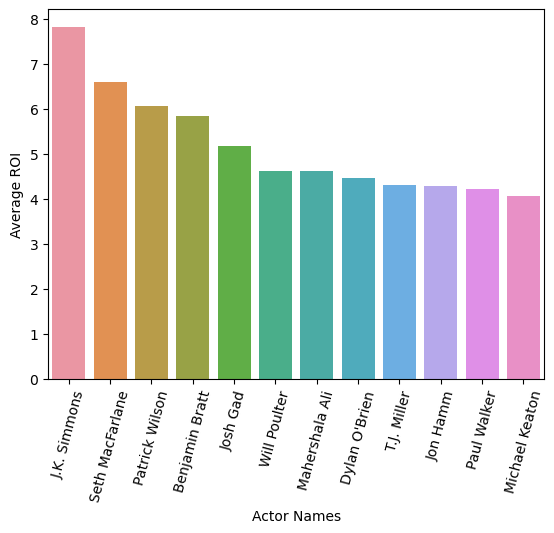

In [22]:
#edit the .head() to view different amounts. typically we viewed the top 12
sns.barplot(data=df1_aq1.head(12), x='Actor Names', y="Average ROI")
plt.xticks(rotation=75)
plt.title('')
plt.show()

## ACTRESSES 
    
### This section outlines actress recommendations. We use a sequence of queries, and loops to narrow the actress that were a part of movies using a 24mil+ budget, and were casted in at least 3 movies since 2010.¶

In [23]:
## The following cell queries the actors dataframe with a $24Mill+ budget.

aq3 = ("""
SELECT person_name, movie, inf_adj_production_budget, ROI, Comedy, Action, Adventure
FROM actresses
WHERE inf_adj_production_budget >= 2.4e7
ORDER BY ROI
""")

actresses_aq3 = pysqldf(aq3)

In [24]:
actresses_aq3

,person_name,movie,inf_adj_production_budget,ROI,Comedy,Action,Adventure
0,Haylie Duff,Foodfight!,58169890,-0.998362,1,1,0
1,Hilary Duff,Foodfight!,58169890,-0.998362,1,1,0
2,Eva Longoria,Foodfight!,58169890,-0.998362,1,1,0
3,Mackenzie Davis,Freaks of Nature,41180555,-0.997850,1,0,0
4,Beverly D'Angelo,Accidental Love,32681495,-0.994791,1,0,0
...,...,...,...,...,...,...,...
1145,Vera Farmiga,The Conjuring,25411137,14.900007,0,0,0
1146,Lucy Boynton,Bohemian Rhapsody,64767356,15.272461,0,0,0
1147,Sophia Lillis,It,42087096,18.927371,0,0,0
1148,Emma Stone,La La Land,24586384,20.317558,1,0,0


In [25]:
#This loop sorts by number of movies, and selects the actresses that have been casted 3 or more

three_movies_aq3 = []
for x, y in zip(actresses_aq3['person_name'].value_counts(), actresses_aq3['person_name'].value_counts().index.tolist()):
    if x >= 3:
        three_movies_aq3.append(y)
    
three_movies_aq3

['Jennifer Lawrence',
 'Emily Blunt',
 'Viola Davis',
 'Amy Adams',
 'Anne Hathaway',
 'Rachel McAdams',
 'Emma Stone',
 'Cameron Diaz',
 'Cate Blanchett',
 'Scarlett Johansson',
 'Julia Roberts',
 'Chloë Grace Moretz',
 'Vera Farmiga',
 'Kristen Wiig',
 'Mila Kunis',
 'Anna Kendrick',
 'Zoe Saldana',
 'Jennifer Aniston',
 'Amanda Seyfried',
 'Helen Mirren',
 'Michelle Monaghan',
 'Jessica Chastain',
 'Maya Rudolph',
 'Angelina Jolie',
 'Charlize Theron',
 'Jennifer Garner',
 'Anna Faris',
 'Rose Byrne',
 'Melissa McCarthy',
 'Meryl Streep',
 'Milla Jovovich',
 'Kristen Bell',
 'Hailee Steinfeld',
 'Kate Winslet',
 'Bryce Dallas Howard',
 'Rooney Mara',
 'Alicia Vikander',
 'Rosamund Pike',
 'Natalie Portman',
 'Teresa Palmer',
 'Reese Witherspoon',
 'Dakota Johnson',
 'Penélope Cruz',
 'Katherine Heigl',
 'Brie Larson',
 'Rebecca Ferguson',
 'Margot Robbie',
 'Helena Bonham Carter',
 'Tina Fey',
 'Keira Knightley',
 'Jennifer Connelly',
 'Alice Braga',
 'Gwyneth Paltrow',
 'Maggie Gra

In [26]:
# This gets two lists, one is the names of actresses, the other is the respective ROIs. 
# This loop also sorts by genres Action, Adventure, Comedy.


names_aq3 = []
ROI_aq3 = []
for x in three_movies_aq3:
    ROI_aq3_mean = actresses_aq3[actresses_aq3['person_name'] == x]['ROI'].mean()
    this_actor = actresses_aq3[actresses_aq3['person_name'] == x]
    if this_actor['Action'].sum() + this_actor['Adventure'].sum() + this_actor['Comedy'].sum() > 0:
        names_aq3.append(x)
        ROI_aq3.append(ROI_aq3_mean)

#This zips the above loops and puts them into a dataframe. The dataframe will be used for visualization.
    
zipped_name_ROI_aq3 = sorted(zip(names_aq3, ROI_aq3), reverse=True)
df1_aq3 = pd.DataFrame(zipped_name_ROI_aq3, columns=['Actress Names', 'Average ROI'])
df1_aq3.sort_values(by='Average ROI', ascending=False, inplace=True)
df1_aq3

,Actress Names,Average ROI
16,Sandra Bullock,8.109692
53,Kristen Wiig,5.580418
104,Bryce Dallas Howard,4.739587
9,Taraji P. Henson,4.389355
55,Kristen Bell,4.289650
...,...,...
67,Jodie Foster,0.383236
33,Noomi Rapace,0.344334
72,Jennifer Jason Leigh,0.344319
105,Britt Robertson,0.213798


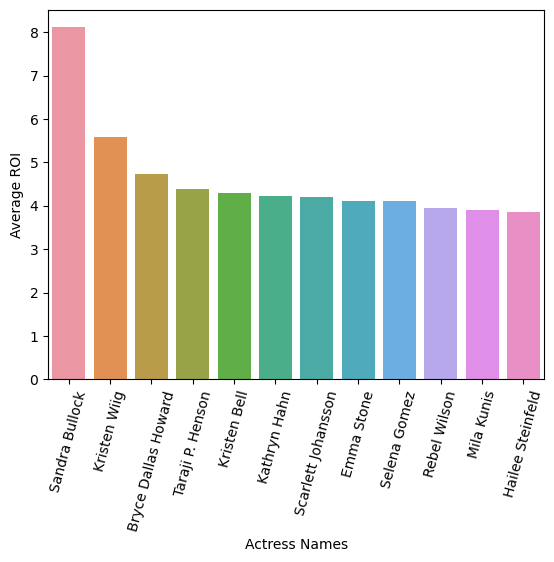

In [27]:
sns.barplot(data=df1_aq3.head(12), x='Actress Names', y="Average ROI")
plt.xticks(rotation=75)
plt.title('')
plt.show()

The following cells queries the actresses that were movies that budgeted 45million or more

## WRITERS

### This section outlines writer recommendations. We use a sequence of queries, and loops to narrow the writers that were a part of movies using a 24mil+ budget, and were casted in at least 3 movies since 2010.¶

In [28]:
## The following cell queries the writers dataframe with a $24Mill+ budget.

wq1 = ("""
SELECT person_name, movie, inf_adj_production_budget, ROI, Comedy, Action, Adventure
FROM writers
WHERE inf_adj_production_budget >= 2.4e7
ORDER BY ROI
""")

writers_wq1 = pysqldf(wq1)

In [29]:
#This loop sorts by number of movies, and selects the writers that have been casted 3 or more

three_movies_wq1 = []
for x, y in zip(writers_wq1['person_name'].value_counts(), writers_wq1['person_name'].value_counts().index.tolist()):
    if x >= 3:
        three_movies_wq1.append(y)
    
three_movies_wq1

['Stan Lee',
 'Jack Kirby',
 'Nicholas Stoller',
 'Stephen McFeely',
 'Christopher Markus',
 'Darren Lemke',
 'Allan Loeb',
 'Luc Besson',
 'Richard Wenk',
 'John Morris',
 'Nicholas Sparks',
 'Mark Bomback',
 'Ken Daurio',
 'John Gatins',
 'Brian Lynch',
 'Jonathan Aibel',
 'Glenn Berger',
 'John Francis Daley',
 'Jonathan Goldstein',
 'Rick Jaffa',
 'Amanda Silver',
 'Jared Stern',
 'Cinco Paul',
 'James Vanderbilt',
 'Jeff Pinkner',
 'John Logan',
 'Jon Spaihts',
 'Michael Green',
 'Josh Singer',
 'Joe Simon',
 'Simon Kinberg',
 'Jez Butterworth',
 'Matt Manfredi',
 'Robert Mark Kamen',
 'Peter Baynham',
 'Christopher McQuarrie',
 'Peter Craig',
 'Ehren Kruger',
 'Michael Arndt',
 'Skip Woods',
 'Aline Brosh McKenna',
 'Dan Fogelman',
 'Suzanne Collins',
 'Simon Beaufoy',
 'Eric Heisserer',
 'Evan Daugherty',
 'Linda Woolverton',
 'Stephen King',
 'Akiva Goldsman',
 'Chris McKenna',
 'Dave Callaham',
 'Philippa Boyens',
 'Seth Grahame-Smith',
 'Rhett Reese',
 'Larry Lieber',
 'Sean 

In [30]:
# This gets two lists, one is the names of writers, the other is the respective ROIs. 
# This loop also sorts by genres Action, Adventure, Comedy.


names_wq1 = []
ROI_wq1 = []
for x in three_movies_wq1:
    ROI_wq1_mean = writers_wq1[writers_wq1['person_name'] == x]['ROI'].mean()
    this_actor = writers_wq1[writers_wq1['person_name'] == x]
    if this_actor['Action'].sum() + this_actor['Adventure'].sum() + this_actor['Comedy'].sum() > 0:
        names_wq1.append(x)
        ROI_wq1.append(ROI_wq1_mean)

#This zips the above loops and puts them into a dataframe. The dataframe will be used for visualization.
    
zipped_name_ROI_wq1 = sorted(zip(names_wq1, ROI_wq1), reverse=True)
df1_wq1 = pd.DataFrame(zipped_name_ROI_wq1, columns=['Writer Names', 'Average ROI'])
df1_wq1.sort_values(by='Average ROI', ascending=False, inplace=True)
df1_wq1

,Writer Names,Average ROI
119,Cinco Paul,8.864475
56,Ken Daurio,8.864475
57,Kelly Marcel,7.306154
12,Stephen King,6.444930
127,Brian Lynch,6.236830
...,...,...
54,Kurt Wimmer,0.732556
133,Allan Loeb,0.527783
88,Hossein Amini,0.486979
80,Jason Keller,0.216173


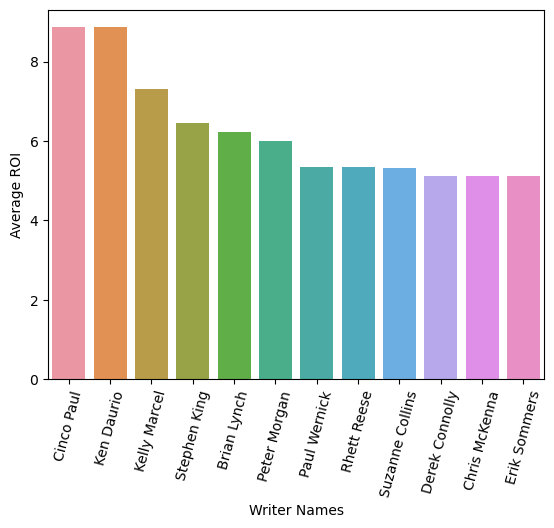

In [31]:
sns.barplot(data=df1_wq1.head(12), x='Writer Names', y="Average ROI")
plt.xticks(rotation=75)
plt.title('')
plt.show()

## Producers

### This section outlines producer recommendations. We use a sequence of queries, and loops to narrow the actress that were a part of movies using a 24mil+ budget, and were casted in at least 3 movies since 2010.¶

In [32]:
## The following cell queries the producers dataframe with a $24Mill+ budget.

pq1 = ("""
SELECT person_name, movie, inf_adj_production_budget, ROI, Comedy, Action, Adventure
FROM producers
WHERE inf_adj_production_budget >= 2.4e7
ORDER BY ROI
""")

producers_pq1 = pysqldf(pq1)

In [33]:
#This loop sorts by number of movies, and selects the producers that have been casted 3 or more

three_movies_pq1 = []
for x, y in zip(producers_pq1['person_name'].value_counts(), producers_pq1['person_name'].value_counts().index.tolist()):
    if x >= 3:
        three_movies_pq1.append(y)
    
three_movies_pq1

['Tim Bevan',
 'Eric Fellner',
 'Lorenzo di Bonaventura',
 'Michael De Luca',
 'Peter Chernin',
 'Broderick Johnson',
 'Neal H. Moritz',
 'Andrew A. Kosove',
 'Beau Flynn',
 'Scott Stuber',
 'Todd Black',
 'Ryan Kavanaugh',
 'Arnon Milchan',
 'Graham King',
 'Wyck Godfrey',
 'Brian Grazer',
 'Scott Rudin',
 'Simon Kinberg',
 'Nina Jacobson',
 'Karen Rosenfelt',
 'Mark Canton',
 'Marc Platt',
 'Marty Bowen',
 'John Davis',
 'Todd Garner',
 'Dana Brunetti',
 'Dede Gardner',
 'Jenno Topping',
 'Shawn Levy',
 'Joe Roth',
 'Jon Kilik',
 'Jason Blumenthal',
 'Anthony Katagas',
 'Charles Roven',
 'Judd Apatow',
 'Basil Iwanyk',
 'Kevin Feige',
 'Chris Bender',
 'Janet Healy',
 'Bill Block',
 'Christopher Meledandri',
 'Patrick Crowley',
 'Frank Marshall',
 'Steve Starkey',
 'Andrew Rona',
 'Jon Jashni',
 'David Hoberman',
 'Randall Emmett',
 'Megan Ellison',
 'Nira Park',
 'Todd Lieberman',
 'Mark Johnson',
 'Jennifer Gibgot',
 'Stacey Sher',
 'Jennifer Davisson',
 'Leonardo DiCaprio',
 'Bria

In [34]:
# This gets two lists, one is the names of producers, the other is the respective ROIs. 
# This loop also sorts by genres Action, Adventure, Comedy.


names_pq1 = []
ROI_pq1 = []
for x in three_movies_pq1:
    ROI_pq1_mean = producers_pq1[producers_pq1['person_name'] == x]['ROI'].mean()
    this_actor = producers_pq1[producers_pq1['person_name'] == x]
    if this_actor['Action'].sum() + this_actor['Adventure'].sum() + this_actor['Comedy'].sum() > 0:
        names_pq1.append(x)
        ROI_pq1.append(ROI_pq1_mean)

#This zips the above loops and puts them into a dataframe. The dataframe will be used for visualization.
    
zipped_name_ROI_pq1 = sorted(zip(names_pq1, ROI_pq1), reverse=True)
df1_pq1 = pd.DataFrame(zipped_name_ROI_pq1, columns=['Producer Names', 'Average ROI'])
df1_pq1.sort_values(by='Average ROI', ascending=False, inplace=True)
df1_pq1.head(20)

,Producer Names,Average ROI
94,Janet Healy,9.668003
129,Christopher Meledandri,7.276575
39,Peter Safran,5.624838
126,Dana Brunetti,5.475595
80,Jonathan Gordon,5.463420
16,Suzanne Todd,5.246161
23,Simon Kinberg,5.210564
114,Donna Gigliotti,4.740473
42,Paul Brooks,4.610706
52,Michael Fottrell,4.579467


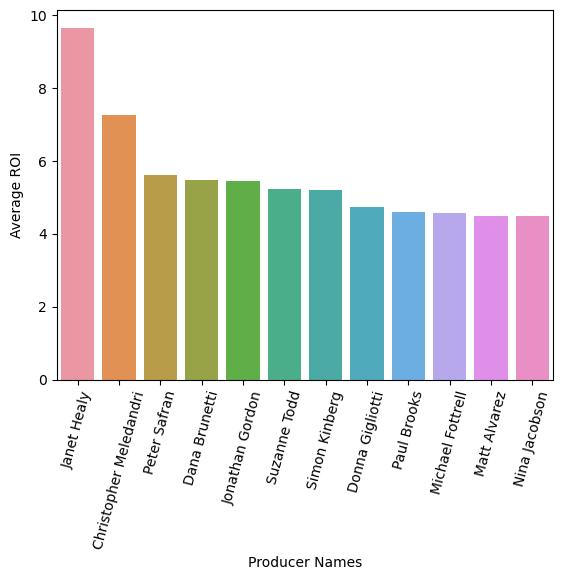

In [35]:
sns.barplot(data=df1_pq1.head(12), x='Producer Names', y="Average ROI")
plt.xticks(rotation=75)
plt.title('')
plt.show()